<a href="https://colab.research.google.com/github/olyaee/Super-Resolution/blob/master/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import glob
import datetime

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


Reading and processing a dataset often becomes timeconsuming. To make a constant stream of data for training hence to keep your GPU busy, you can prefetch several batches. To do so, you have to apply .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
By using autotune, you allow TF to find the optimal buffer size.
```
dataset.shuffle(5).batch(5).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
```




In [0]:
data_dir = './drive/My Drive/data/SRCNN/'
log_dir = './drive/My Drive/logs/'
model_dir = './drive/My Drive/Models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir) 

In [0]:
train_glob = sorted(glob.glob(data_dir+'Train/*.bmp'))
test_glob = sorted(glob.glob(data_dir+'Test/*/*.bmp'))
print('train ds images:', len(train_glob),train_glob)
print('test ds images:', len(test_glob),test_glob)

train ds images: 91 ['./drive/My Drive/data/SRCNN/Train/t1.bmp', './drive/My Drive/data/SRCNN/Train/t10.bmp', './drive/My Drive/data/SRCNN/Train/t11.bmp', './drive/My Drive/data/SRCNN/Train/t12.bmp', './drive/My Drive/data/SRCNN/Train/t13.bmp', './drive/My Drive/data/SRCNN/Train/t14.bmp', './drive/My Drive/data/SRCNN/Train/t15.bmp', './drive/My Drive/data/SRCNN/Train/t16.bmp', './drive/My Drive/data/SRCNN/Train/t17.bmp', './drive/My Drive/data/SRCNN/Train/t18.bmp', './drive/My Drive/data/SRCNN/Train/t19.bmp', './drive/My Drive/data/SRCNN/Train/t2.bmp', './drive/My Drive/data/SRCNN/Train/t20.bmp', './drive/My Drive/data/SRCNN/Train/t21.bmp', './drive/My Drive/data/SRCNN/Train/t22.bmp', './drive/My Drive/data/SRCNN/Train/t23.bmp', './drive/My Drive/data/SRCNN/Train/t24.bmp', './drive/My Drive/data/SRCNN/Train/t25.bmp', './drive/My Drive/data/SRCNN/Train/t26.bmp', './drive/My Drive/data/SRCNN/Train/t27.bmp', './drive/My Drive/data/SRCNN/Train/t28.bmp', './drive/My Drive/data/SRCNN/Train/t

In [0]:
BATCH_SIZE = 128
EPOCHS = 10
DOWNSCALNG_FACTOR = 3
PATCH_STRIDE = 14 #14
PATCH_GT_SIZE = 21 #21
PATCH_INPUT_SIZE = 33 #33
SAVE_MODEL_PERIOD =500

* Rgb2YCbCr conversion can be found [here](https://github.com/PatWie/tensorflow-recipes/blob/master/SubPixelSuperResolution/realtime_superresolution.py)


In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_bmp(img, channels=3)
  img = tf.dtypes.cast(img, tf.float32)
  # find lumincance channel  and then convert to floats in the [0, 1] range
  img = 0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2]
  img = tf.image.convert_image_dtype(tf.dtypes.cast(img, tf.uint8), tf.float32)

  img = tf.expand_dims(img, axis=2)
  return img
  
def process_path(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

def down_up(img, downscaling_factor=DOWNSCALNG_FACTOR):
  img = tf.image.resize(img, [tf.shape(img)[0]/DOWNSCALNG_FACTOR, tf.shape(img)[1]/DOWNSCALNG_FACTOR], method="bicubic")
  img = tf.image.resize(img, [tf.shape(img)[0]*DOWNSCALNG_FACTOR, tf.shape(img)[1]*DOWNSCALNG_FACTOR], method="bicubic")
  return img

def modcrop(img, scale=DOWNSCALNG_FACTOR):
  h = tf.shape(img)[0]
  # print('111', np.array(h))
  w = tf.shape(img)[1]
  # print(h)
  h = h - tf.math.mod(h, scale)
  w = w - tf.math.mod(w, scale)
  img = img[0:h, 0:w, :]
  return img

def get_patches(img, is_gt, stride=PATCH_STRIDE, patch_gt_size=PATCH_GT_SIZE, patch_input_size=PATCH_INPUT_SIZE):
  img = tf.expand_dims(img, 0)
  if is_gt is True:
    start=int((patch_input_size-patch_gt_size)/2)
    img = img[:, start:-start, start:-start, :]
    img = tf.image.extract_patches(img, 
                                  sizes=[1, patch_gt_size, patch_gt_size, 1], 
                                  strides=[1, stride, stride, 1],
                                  rates=[1, 1, 1, 1], 
                                  padding='VALID')
    img = tf.reshape(img, shape=[-1, patch_gt_size, patch_gt_size, 1])

  else:
    img = tf.image.extract_patches(img, 
                                  sizes=[1, patch_input_size, patch_input_size, 1], 
                                  strides=[1, stride, stride, 1],
                                  rates=[1, 1, 1, 1], 
                                  padding='VALID')
    img = tf.reshape(img, shape=[-1, patch_input_size, patch_input_size, 1])

  return img


#A buffer size greater than or equal to the full size of the dataset is required.
def prepare_for_training(ds, batch_size=1, shuffle_buffer_size=20000):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)

  ds = ds.repeat(1)

  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

ds_train_len 21884


<function matplotlib.pyplot.show>

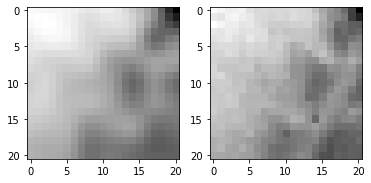

In [0]:
def dataset_map(list_dataset, is_gt):
  if is_gt==True:
    processed_ds = list_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
    modcroped_ds = processed_ds.map(modcrop, num_parallel_calls=AUTOTUNE)
    patched_ds = modcroped_ds.map(lambda x: get_patches(x, is_gt=True), num_parallel_calls=AUTOTUNE)
  else:
    processed_ds = list_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
    modcroped_ds = processed_ds.map(modcrop, num_parallel_calls=AUTOTUNE)
    down_up_ds = modcroped_ds.map(down_up, num_parallel_calls=AUTOTUNE)
    patched_ds = down_up_ds.map(lambda x: get_patches(x, is_gt=False), num_parallel_calls=AUTOTUNE)
  ubatched_ds = patched_ds.unbatch()
  return ubatched_ds

list_train_gt = tf.data.Dataset.from_tensor_slices(train_glob)
ds_train_hr = dataset_map(list_train_gt, is_gt=True)

list_train_input = tf.data.Dataset.from_tensor_slices(train_glob)
ds_train_lr = dataset_map(list_train_input, is_gt=False)

ds_train_len = len(list(ds_train_lr))
print('ds_train_len', ds_train_len)

ds_train = tf.data.Dataset.zip((ds_train_lr, ds_train_hr))
ds_train = prepare_for_training(ds_train, batch_size=BATCH_SIZE, shuffle_buffer_size=ds_train_len)


input, gt = next(iter(ds_train))
plt.subplot(1, 2, 1)
plt.imshow(input[0, 6:-6, 6:-6, 0], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(gt[0, :, :, 0], 'gray')
plt.show

In [0]:
# log checkpoint
logdir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# model checkpoint
saved_models = sorted(glob.glob(model_path+'*.h5'))
initial_epoch=0
if len(saved_models) is not 0:
  last_epoch_name = saved_models[-1]
  initial_epoch = int(str(last_epoch_name)[-9:-3])
filepath = model_dir+"{epoch:06d}.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_freq=ds_train_len*SAVE_MODEL_PERIOD)

# model
initializer = tf.random_normal_initializer(0., 0.02)
bias_initializer = tf.zeros_initializer()

input = tf.keras.Input(shape=(33, 33, 1))
conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=9, strides=1,
                                kernel_initializer=initializer,
                                use_bias=True,
                                bias_initializer=bias_initializer, 
                                activation='relu')(input)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=1, strides=1,
                                kernel_initializer=initializer,
                                use_bias=True,
                                bias_initializer=bias_initializer,
                                activation='relu')(conv1)

output = tf.keras.layers.Conv2D(filters=1, kernel_size=5, strides=1,
                                kernel_initializer=initializer,
                                use_bias=True,
                                bias_initializer=bias_initializer)(conv2) 

model  = tf.keras.Model(inputs=input, outputs=output)
 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse')
print(model.summary())
history = model.fit(ds_train, epochs=150000, verbose=2, initial_epoch=initial_epoch, callbacks=[tensorboard_callback, model_checkpoint])


26500


In [0]:
%tensorboard --logdir "./drive/My Drive/logs1/"

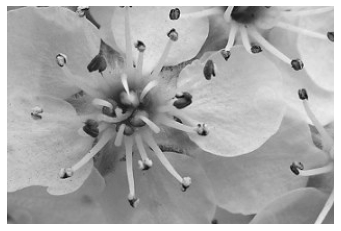

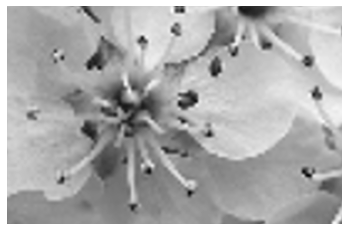

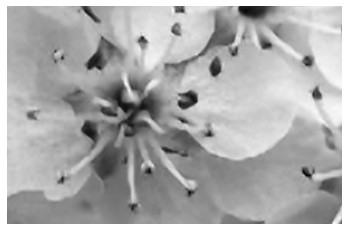

In [0]:
model = tf.keras.models.load_model('./drive/My Drive/Models/026000.h5')

list_test_gt = tf.data.Dataset.from_tensor_slices(train_glob)
processed_test_gt_ds = list_test_gt.map(process_path, num_parallel_calls=AUTOTUNE)

down_up_test_ds = processed_test_gt_ds.map(down_up, num_parallel_calls=AUTOTUNE)

ds_test = tf.data.Dataset.zip((down_up_test_ds, processed_test_gt_ds))
ds_test = test_ds.shuffle(1000)

input, gt = next(iter(ds_test))

image_hr= gt
image_lr= input
output = model(image_lr)


plt.figure()
plt.imshow(image_hr[0,:, :, 0],cmap='gray')
plt.axis('off')
plt.figure()
plt.imshow(image_lr[0, 6:-6:, 6:-6, 0],cmap='gray')
plt.axis('off')
plt.figure()
plt.imshow(output[0, :, :, 0],cmap='gray')
plt.axis('off')

plt.imsave("hr.jpg", image_hr[0, :, :, 0], cmap='gray')
plt.imsave("lr.jpg", image_lr[0, 6:-6:, 6:-6, 0], cmap='gray')
plt.imsave("sr.jpg", output[0, :, :, 0], cmap='gray')